First question is: If I want to calculate the elongation rates at resolution of 200-bp, and in this simulation the elongation rate is constant across the gene, can I recover the elongation rate from the data?

In [1]:
import sys
import os
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))  # this line does not work because it is not designed to be run within the notebook
os.chdir('/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations')
import numpy as np
import unittest
import pandas as pd
import visualize_simulations as viz
import transcription.simulate_multiple_experiments as sim
import transcription.helper as helper
from estimates.elongation import estElong
from estimates.elongation import drop_trailing_zeros
from pandas.testing import assert_series_equal
target_exp = 5
num_total_transcript_millions = 100
ONE_KB=1000
degrade_rate = 0.00
intron_h = 5
PAS_h=5
RTR=500
lambda_init = 2 # average number of burst events per minute (burst event is the event where a burst_size transcripts are created around the same time)
burst_size = 10 # number of transcripts created in a burst event
wiggle_room = 0.3 # the wiggle room for the burst event. See the comments in function Experiment.init_bursting_transcripts to understand the meaning of this parameter. If not sure, don't modify it.
# if I want to simulate situation such that there is no read being generated from fragments (only the whole transcripts are sequenced), the following parameters should be set carefully:
eta_val=helper.DFT_ETA_VALUE  # the scale fo weibull distribution for the fragment length
insertsize_min = -1 #200  #filter fragments minimum length
insertsize_max = -1 #300  # filter fragments maximum length
read_length = -1 #150 # the length of the reads
frag_func= 'weibull_edge' # whether we will simulate the fragmentation of transcripts based on the weibull distribution or the uniform fragmentation method
unif_avg_frag_len=250 # the desired average fragment length if we use the uniform fragmentation method
# if I set the read values to -1, the program will just generate fragments and not get rid of any portion of the fragments.
simulate_cleavage=False ## for this problem, we don't need to simulate cleavage because we really only care about calculating the elongation speed of the transcripts. We skip splicing and cleavage for now.
PDB = False  # whether we simulate a system where there is no existing transcripts, and instead we used PDB to stop the transcripts from elongation, and let the elongation to start PDB_time minutes before we introduce the first tag
label_time = np.arange(4) if PDB else np.arange(3)
time_interval=5
label_time = time_interval*label_time
num_timepoints = len(label_time)
max_time_for_equilibrium = 50
save_folder = None # './exon2_4Fold/'


importing simulate_multiple_experiments


In [3]:
# first generate the experiments with different ground truth elongation rates
true_h = 0.11
save_folder = f'./constant_elongation/h_{true_h}/'
os.makedirs(save_folder, exist_ok=True)
gtf_df = sim.create_variable_gtf_df(nExons=2, length_fold_list=[1.65, 1.65, 1.65],
                                    elong_fold_list=[true_h, true_h, true_h], intronH_fold_list=[np.inf] * 3,
                                    SIM_FEAT_LEN=ONE_KB)
exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder=None, label_time=label_time,
                                          target_exp=target_exp,
                                          num_total_transcript_millions=num_total_transcript_millions,
                                          lambda_init=lambda_init, burst_size=burst_size,
                                          wiggle_room=wiggle_room, eta_val=eta_val,
                                          insertsize_min=insertsize_min, insertsize_max=insertsize_max,
                                          read_length=read_length, simulate_cleavage=simulate_cleavage, PDB=PDB,
                                          max_time_for_equilibrium=max_time_for_equilibrium,
                                          frag_func=frag_func)
endpoint_df = viz.get_endpoints_across_time(exp_list)
coverage_df = viz.count_timeDep_read_coverage(exp_list[-1], endpoint_df, N=1, num_timepoints=len(exp_list))
coverage_df.to_csv(f'{save_folder}/coverage.csv.gz', header = True, index = False, compression='gzip', sep = '\t')

inside generate_exp_given_one_gtf
before adding new experiments
1050
1160
1240


In [5]:
# now we will estimate the elongation rates from the data
from estimates import elongation
import importlib
importlib.reload(elongation)
from estimates.elongation import estElong
def calculate_h_one_trueH(true_h):
    save_folder = f'./constant_elongation/h_{true_h}/'
    coverage_df = pd.read_csv(f'{save_folder}/coverage.csv.gz', sep = '\t', index_col=None, header=0)
    coverage_df.columns = [0,1,2, 'position']
    gtf_df = sim.create_variable_gtf_df(nExons=2, length_fold_list=[1.65, 1.65, 1.65],
                                        elong_fold_list=[true_h, true_h, true_h], intronH_fold_list=[np.inf] * 3,
                                        SIM_FEAT_LEN=ONE_KB)
    elong_estimator = estElong(coverage_df, gtf_df)
    elong_estimator.estimate()
    df = pd.DataFrame({'x0': elong_estimator.x0, 'x1': elong_estimator.x1})
    df.to_csv(f'{save_folder}/x0_x1.csv.gz', header = True, index = False, compression='gzip', sep = '\t')
    return
    elong_estimator.draw_regression_lines(save_fn=f'{save_folder}/test_estElong_regression.png', show=True)
    elong_estimator.save_estimates(f'{save_folder}/pred_h.csv.gz')
    return 

# calculate_h_one_trueH(0.132)
# calculate_h_one_trueH(0.11)
# calculate_h_one_trueH(0.165)
# calculate_h_one_trueH(0.22)
# calculate_h_one_trueH(0.33)
# calculate_h_one_trueH(0.66)
calculate_h_one_trueH(1.65)

The object assumes that the length and coordinates of features in both coverage_df and gtf_df are in the same units (bp or KB)
If this assumption is not met, the object may not crash but may result in seriously wrong estimates of elongation rates

Starting estimating the elongation rates
fixed. py[i] - curr_y:  0.01695834418504205
py[i]:  131.0
curr_y:  130.98304165581496
fixed. py[i] - curr_y:  0.01695834418504205
py[i]:  131.0
curr_y:  130.98304165581496
fixed. py[i] - curr_y:  0.01695834418504205
py[i]:  131.0
curr_y:  130.98304165581496
fixed. py[i] - curr_y:  0.01695834418504205
py[i]:  131.0
curr_y:  130.98304165581496
fixed. py[i] - curr_y:  0.010150341705539745
py[i]:  118.0
curr_y:  117.98984965829446
fixed. py[i] - curr_y:  0.1403044999548797
py[i]:  91.06540361296422
curr_y:  90.92509911300934
fixed. py[i] - curr_y:  1.423242846675862
py[i]:  370.42324284667586
curr_y:  369.0
fixed. py[i] - curr_y:  0.21086475937545401
py[i]:  348.0
curr_y:  347.78913524062455
fixed. py[i] -

Text(0.5, 1.0, 'Predicted h vs True h')

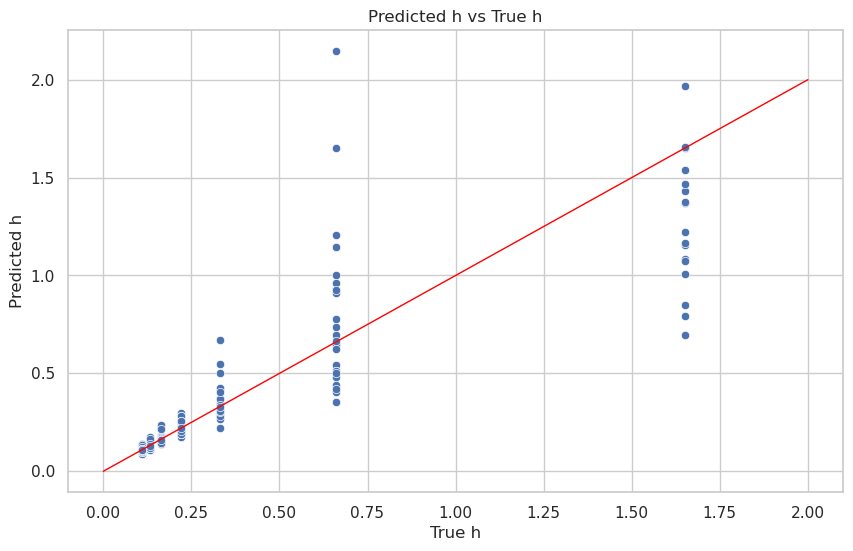

In [18]:
true_h_list = [1.65, 0.66, 0.33, 0.22, 0.165, 0.132, 0.11]
pred_h_fn_list = [f'./constant_elongation/h_{true_h}/pred_h.csv.gz' for true_h in true_h_list]
def read_pred_h(fn):
    df = pd.read_csv(fn, sep = '\t', index_col=None, header=0)
    df.rename({'elongation_rate': 'pred_h'}, axis=1, inplace=True)
    true_h = float(fn.split('/')[-2].split('_')[-1])  # from /path/to/truth_h/pred_h.csv.gz, get the true h
    df['true_h'] = true_h
    return df 
pred_h_df = pd.concat([read_pred_h(fn) for fn in pred_h_fn_list])
pred_h_df = pred_h_df[(pred_h_df['pred_h'] > 0)  & (pred_h_df['pred_h']<3)]  # remove the negative values
# draw a plot such that x-axis is the true h, and y-axis is the predicted h
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='true_h', y='pred_h', data=pred_h_df)
plt.plot([0, 2], [0, 2], color='red', linewidth=1)
plt.xlabel('True h')
plt.ylabel('Predicted h')
plt.title('Predicted h vs True h')